In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from nlp_dauphine.preprocess_data import (
        load_data, 
        text_cleaning, 
        link_texts_series, 
        suppr_footnotes, 
        categorical_other
        )
from nlp_dauphine.embeddings import vocabulary
from nlp_dauphine.utils import set_working_dir
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from category_encoders import WOEEncoder

In [3]:
set_working_dir()

Current working dir: c:/Users/Hugo/Documents/Travail/A5/Dauphine_challenge/nlp_dauphine/notebooks
New working dir: c:/Users/Hugo/Documents/Travail/A5/Dauphine_challenge/nlp_dauphine


# Load Data

In [4]:
path = Path("data")
files_path = {
    "ecb": Path(path,"ecb_data.csv"),
    "fed": Path(path,"fed_data.csv"),
    "train_series": Path(path,"train_series.csv"),
}

In [6]:
# LOAD TEXT DATA
df_ecb, df_fed, df_train_series = load_data(files_path)
print(df_ecb.shape, df_fed.shape, df_train_series.shape)

(1772, 3) (739, 3) (8946, 14)


# Text Cleaning

## Link Texts to Series

Create some indices

In [7]:
df_ecb.reset_index(inplace=True, names="id_ecb")
df_fed.reset_index(inplace=True, names="id_fed")
df_train_series.reset_index(inplace=True, names="id_series")

Create a list rather than a string with a comma separator

In [8]:
df_train_series["id_ecb"] = [x.split(",") for x in df_train_series['index ecb']]
df_train_series["id_fed"] = [x.split(",") for x in df_train_series['index fed']]
del df_train_series['index ecb']
del df_train_series['index fed']

## Remove Footnotes

In [9]:
df_ecb["text_process"] = df_ecb.text.apply(lambda x: suppr_footnotes(x))
df_fed["text_process"] = df_fed.text.apply(lambda x: suppr_footnotes(x))

## Deal with Null Values

In [10]:
# REPLACE NULL TEXTS BY TITLE
index_no_texts = df_ecb[df_ecb["text_process"].isnull()].index.values
df_ecb.loc[index_no_texts, "text_process"] = df_ecb.loc[index_no_texts, "title"].values

## Remove special characters, stop words, Lemmatization...

In [27]:
# Clean Data
negation_words = ["no", "not"]
df_fed.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    ) for x in df_fed.text_process]
df_ecb.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    ) for x in df_ecb.text_process]

done


Less efficient 

In [ ]:
"""# CLEAN TEXTS
negation_words = ["no", "not"]
df_fed.text_process = df_fed.text_process.apply(
    lambda x: text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    )
)
df_ecb.text_process = df_ecb.text_process.apply(
    lambda x: text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    )
)"""

In [70]:
df_fed.text_process = a 
df_ecb.text_process = b

Length of the texts

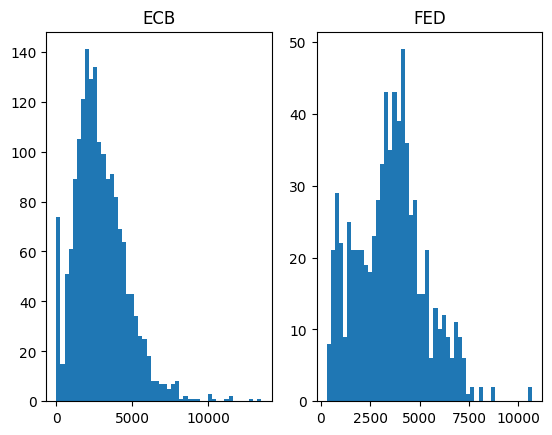

In [13]:
lenght_texts_ecb = [len(str(x).split(" ")) for x in df_ecb.text]
lenght_texts_fed = [len(str(x).split(" ")) for x in df_fed.text]
fig, ax = plt.subplots(1,2)
ax[0].hist(lenght_texts_ecb, bins=50)
ax[0].set_title("ECB")
ax[1].hist(lenght_texts_fed, bins=50)
ax[1].set_title("FED")
plt.show()

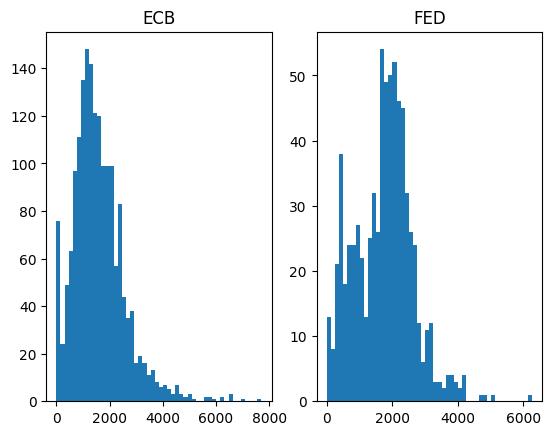

In [61]:
lenght_texts_ecb = [len(str(x).split(" ")) for x in df_ecb.text_process]
lenght_texts_fed = [len(str(x).split(" ")) for x in df_fed.text_process]
fig, ax = plt.subplots(1,2)
ax[0].hist(lenght_texts_ecb, bins=50)
ax[0].set_title("ECB")
ax[1].hist(lenght_texts_fed, bins=50)
ax[1].set_title("FED")
plt.show()

In [ ]:
#np.where(np.array(lenght_texts_ecb).astype('int64')<200)

# Categorical Variable: Speakers

In [12]:
df_fed.speaker.value_counts()

Chairman Ben S. Bernanke                        145
Governor Lael Brainard                           68
Governor Daniel K. Tarullo                       54
Governor Jerome H. Powell                        50
Vice Chairman Stanley Fischer                    45
Governor Elizabeth A. Duke                       44
Chair Janet L. Yellen                            44
Vice Chairman Donald L. Kohn                     41
Vice Chair for Supervision Randal K. Quarles     39
Governor Randall S. Kroszner                     36
Chairman Jerome H. Powell                        32
Governor Frederic S. Mishkin                     26
Vice Chairman Richard H. Clarida                 26
Vice Chair Janet L. Yellen                       22
Governor Sarah Bloom Raskin                      17
Governor Kevin Warsh                             16
Governor Jeremy C. Stein                         16
Governor Michelle W. Bowman                      13
Governor Susan S. Bies                            3
Name: speake

In [71]:
df_ecb.speaker = categorical_other(df_ecb.speaker)
df_fed.speaker = categorical_other(df_fed.speaker, threshold=0.025)

# Text Concatenation

In [13]:
df_train_series.head()

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index + 1,id_ecb,id_fed
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,0.010597,"[1126, 1471]",[96]
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,0.007422,0.000000,0.014492,[975],[568]
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,0.005040,0.000156,0.016263,"[78, 806]","[328, 695]"
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,0.001018,-0.002582,0.013581,"[560, 1405]",[118]
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,-0.000729,-0.000365,0.005092,[404],[261]


In [72]:
df_series_ecb_process = link_texts_series(df_train_series, df_ecb, "id_series", "id_ecb")
df_series_fed_process = link_texts_series(df_train_series, df_fed, "id_series", "id_fed")

In [73]:
df_train_series = df_train_series.merge(df_series_ecb_process,on='id_series',how='left')
df_train_series = df_train_series.merge(df_series_fed_process,on='id_series',how='left')
df_train_series.head()

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index + 1,id_ecb,id_fed,text_concat_ecb,list_speakers_ecb,text_concat_fed,list_speakers_fed
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,0.010597,"[1126, 1471]",[96],welcome address welcome remark philip r lane m...,"[Philip R. Lane, Luis de Guindos]",delighted helsinki important conference moneta...,[Vice Chairman Richard H. Clarida]
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,0.007422,0.000000,0.014492,[975],[568],monetary policy structural reform euro area sp...,[Mario Draghi],watch live would like thank federal reserve ba...,[Vice Chairman Stanley Fischer]
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,0.005040,0.000156,0.016263,"[78, 806]","[328, 695]",challenge opportunity reboot european financia...,"[Benoît Cœuré, Benoît Cœuré]",grateful national association business economi...,"[Vice Chairman Stanley Fischer, Governor Lael ..."
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,0.001018,-0.002582,0.013581,"[560, 1405]",[118],create stability uncertain world speech peter ...,"[Peter Praet, Peter Praet]",thank invitation speak today begin take stock ...,[Governor Jerome H. Powell]
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,-0.000729,-0.000365,0.005092,[404],[261],money private currency reflection libra speech...,[Yves Mersch],year symposium topic challenge monetary policy...,[Chairman Jerome H. Powell]


# Removal Zero value Time series

Probably due to a score approximation 

Some times all indices are null

In [118]:
df_train_series.loc[df_train_series['Index + 1']==0.0]['Index Name'].value_counts()

SRVIX Index         428
CVIX Index           70
MOVE Index           50
VIX Index            41
V2X Index            36
SPX Index            36
SX5E Index           25
EURUSDV1M Curncy     13
EURUSD Curncy         7
Name: Index Name, dtype: int64

In [123]:
sup = df_train_series.loc[df_train_series['Index + 1']==0.0].index
df_train_series.drop(sup,inplace=True)

In [144]:
df_train_series.to_csv("./data/train_series_clean_no_0.csv")

# Train Test Split

In [124]:
# Train test split 
X=df_train_series.loc[:,df_train_series.columns!="Index + 1"]
y=df_train_series[["Index + 1"]]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)
print(X_train.shape,y_train.shape)

(6592, 18) (6592, 1)


Binary Classification

In [125]:
y_t = np.sign(y_train)
y_t.value_counts()

Index + 1
-1.0         3364
 1.0         3228
dtype: int64

In [ ]:
from pandas.plotting import lag_plot
lag_plot(series)
pyplot.show()

# Categorical Encoding 

In [142]:
col_speakers = ["speaker_"+str(i+1) for i in range(4)]
test_conc = pd.concat([X_train, X_train['list_speakers_ecb'].apply(pd.Series)], axis=1)
test_conc.rename({i:col for i, col in enumerate(col_speakers)},axis=1,inplace=True)
enc = WOEEncoder(cols=col_speakers)
tr = enc.fit_transform(test_conc, y_t)
tr.fillna(0,inplace=True)

c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [143]:
tr.head()

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,...,id_ecb,id_fed,text_concat_ecb,list_speakers_ecb,text_concat_fed,list_speakers_fed,speaker_1,speaker_2,speaker_3,speaker_4
5885,5885,EURUSDV1M Curncy,-0.020409,-0.010363,0.058171,-0.012361,-0.004988,-0.043430,-0.064713,0.022039,...,[782],[300],sepa go live speech gertrude tumpel gugerell m...,[Gertrude Tumpel-Gugerell],remark today would like consider rationale gre...,[Governor Frederic S. Mishkin],0.996021,-0.707162,-0.121054,0.056732
7271,7271,EURUSD Curncy,-0.000897,-0.001797,-0.001260,-0.002434,0.001984,0.000540,0.000810,0.002605,...,[1678],"[356, 456]",laudatory speech laudatory speech christine la...,[Christine Lagarde],delight back new particularly company many stu...,"[Vice Chair for Supervision Randal K. Quarles,...",1.541585,-0.707162,-0.121054,0.056732
1391,1391,SPX Index,0.009359,0.007187,0.000733,0.015262,-0.000155,0.001195,-0.029243,0.005964,...,"[1090, 1739, 749, 637]",[314],imbalance sustainability euro area slide prese...,"[Lorenzo Bini Smaghi, Vítor Constâncio, Jürgen...",behalf board governors federal reserve system ...,[Governor Elizabeth A. Duke],0.368791,1.035421,0.000000,0.000000
1274,1274,EURUSDV1M Curncy,0.010245,0.029922,0.011670,-0.044995,-0.011429,-0.007499,0.095468,-0.002107,...,[277],"[199, 372]",restart market case interbank market speech lo...,[Lorenzo Bini Smaghi],financial system turmoil past month credit con...,"[Chairman Ben S. Bernanke, Governor Randall S....",0.368791,-0.707162,-0.121054,0.056732
2189,2189,SX5E Index,0.008022,0.000849,0.004068,0.002454,-0.014174,0.014222,0.010770,0.001143,...,[176],[147],know unknowns central clear speech benoît cœyo...,[Benoît Cœuré],today talk federal reserve help nation recover...,[Chair Janet L. Yellen],0.228748,-0.707162,-0.121054,0.056732


# Embeddings

## Build a vocabulary

## Create the co-occurence Matrix

## Embeddings from the co-occurence Matrix

### SVD

## Sentence Representations

# Save Data